In [1]:
cd ../src/models

/Users/adamnavarroliriano/Documents/Personal/Code/forecast/forecast-sktime/src/models


In [2]:
import pandas as pd
import numpy as np
from plotnine import *
from sktime.param_est.stationarity import StationarityADF
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.utils.plotting import plot_series
from matplotlib import pyplot as plt

from utils.config import get_model_params, get_env_params
from utils.data import load_data, split_timeseries

## Read data

In [3]:
# Read data
data = load_data('main')
train_data, test_data = split_timeseries(data, 12)
env_params = get_env_params("main")

## Summary statistics and cheks

In [4]:
# Check summary statistics.
train_data[["y"]].describe()

,y
count,62.000000
mean,2.498376
std,0.606541
min,1.447330
25%,1.980307
50%,2.485690
75%,2.919247
max,3.791290


In [5]:
# Check for NaN values
assert train_data["y"].isna().sum() == 0, "There are missing values"

In [6]:
# Compute date column and get the possible range to see that there are no missing dates
train_data["date"] = pd.to_datetime(train_data.index, format="%d.%m.%y")
date_range = pd.date_range(
    train_data["date"].iloc[0], train_data["date"].iloc[-1], freq="MS"
)


assert date_range.shape[0] == train_data.shape[0], "There is missing data"
assert (
    date_range == train_data["date"]
).all(), "There is data not in the date interval"

/var/folders/2r/qqty3m710jx81h6c4fh55t2c0000gn/T/ipykernel_31259/2634180703.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


## Plots + Stationary

In [7]:
def test_stationary(X) -> dict:
    sty_adf = StationarityADF(p_threshold=0.05, maxlag=12)
    sty_adf.fit(X.reset_index(drop=True).dropna())

    return sty_adf.get_fitted_params()
    

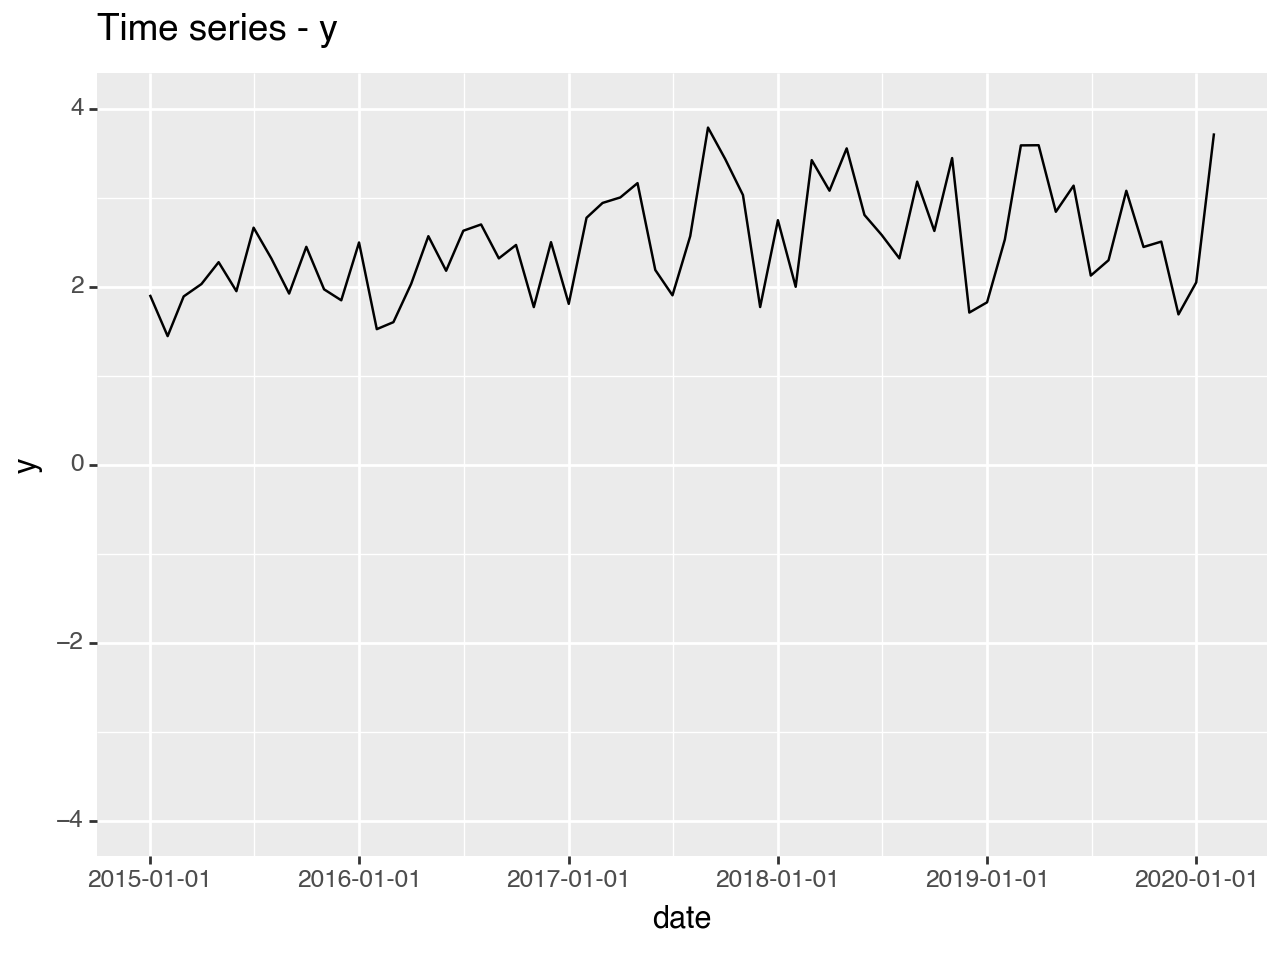


{'pvalue': 0.11642557377237572, 'stationary': False, 'test_statistic': -2.496102243247205, 'used_lag': 4}


In [8]:
print(
    ggplot(train_data, aes(x="date", y="y"))
    + geom_line()
    + coord_cartesian(ylim=[0, train_data["y"].max() + 0.5])
    + coord_cartesian(ylim=[-4, 4]) 
    + labs(title="Time series - y")
)
print(test_stationary(train_data['y']))

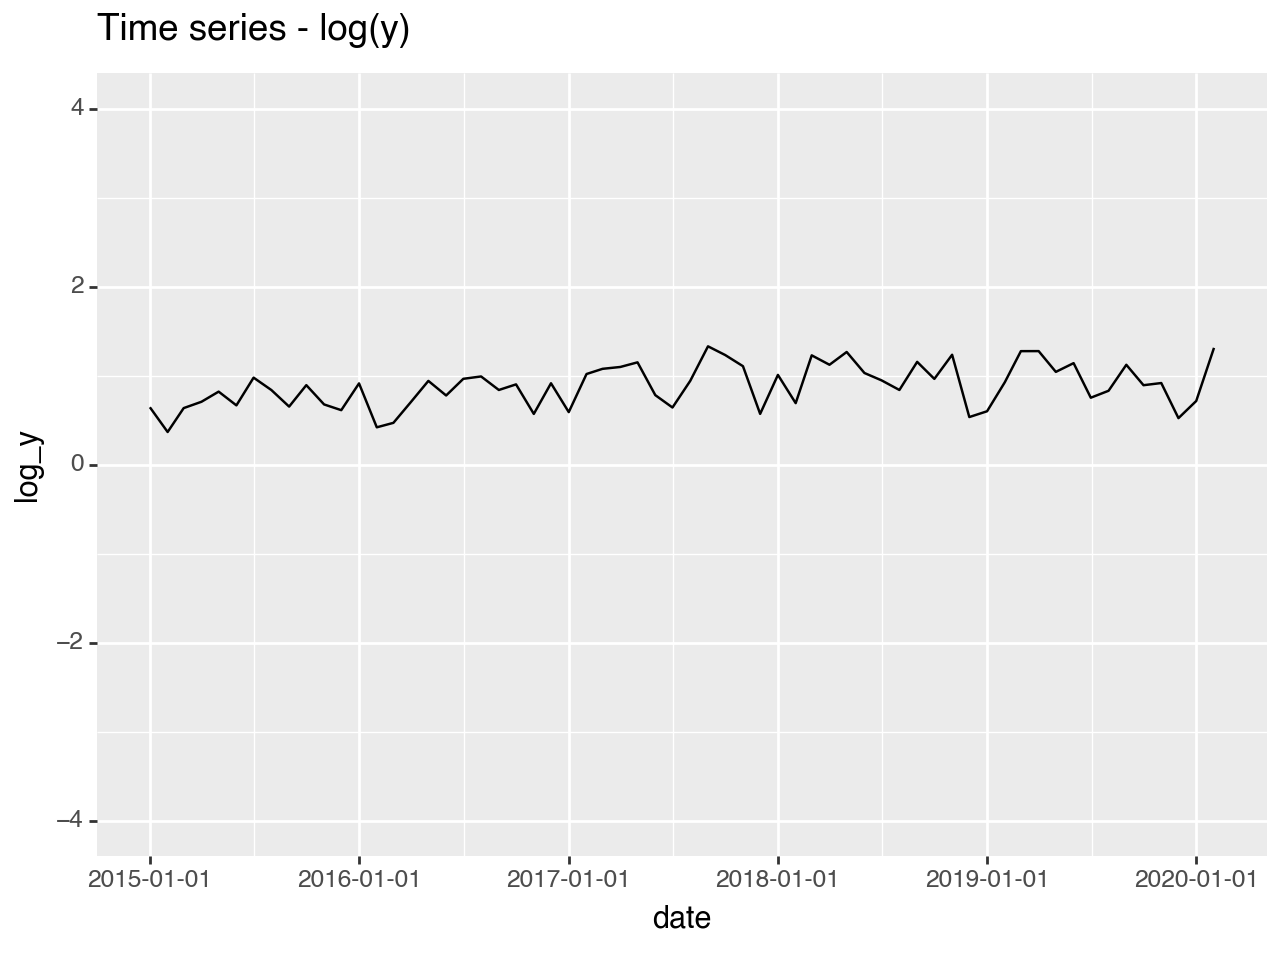


{'pvalue': 0.08221421453071526, 'stationary': False, 'test_statistic': -2.6546801335014782, 'used_lag': 4}


In [9]:
print(
    ggplot(train_data.assign(log_y=np.log(train_data["y"])), aes(x="date", y="log_y"))
    + geom_line()
    + coord_cartesian(ylim=[0, np.log(train_data["y"]).max() + 0.5])
    + coord_cartesian(ylim=[-4, 4]) 
    + labs(title="Time series - log(y)")
)
print(test_stationary(np.log(train_data['y'])))

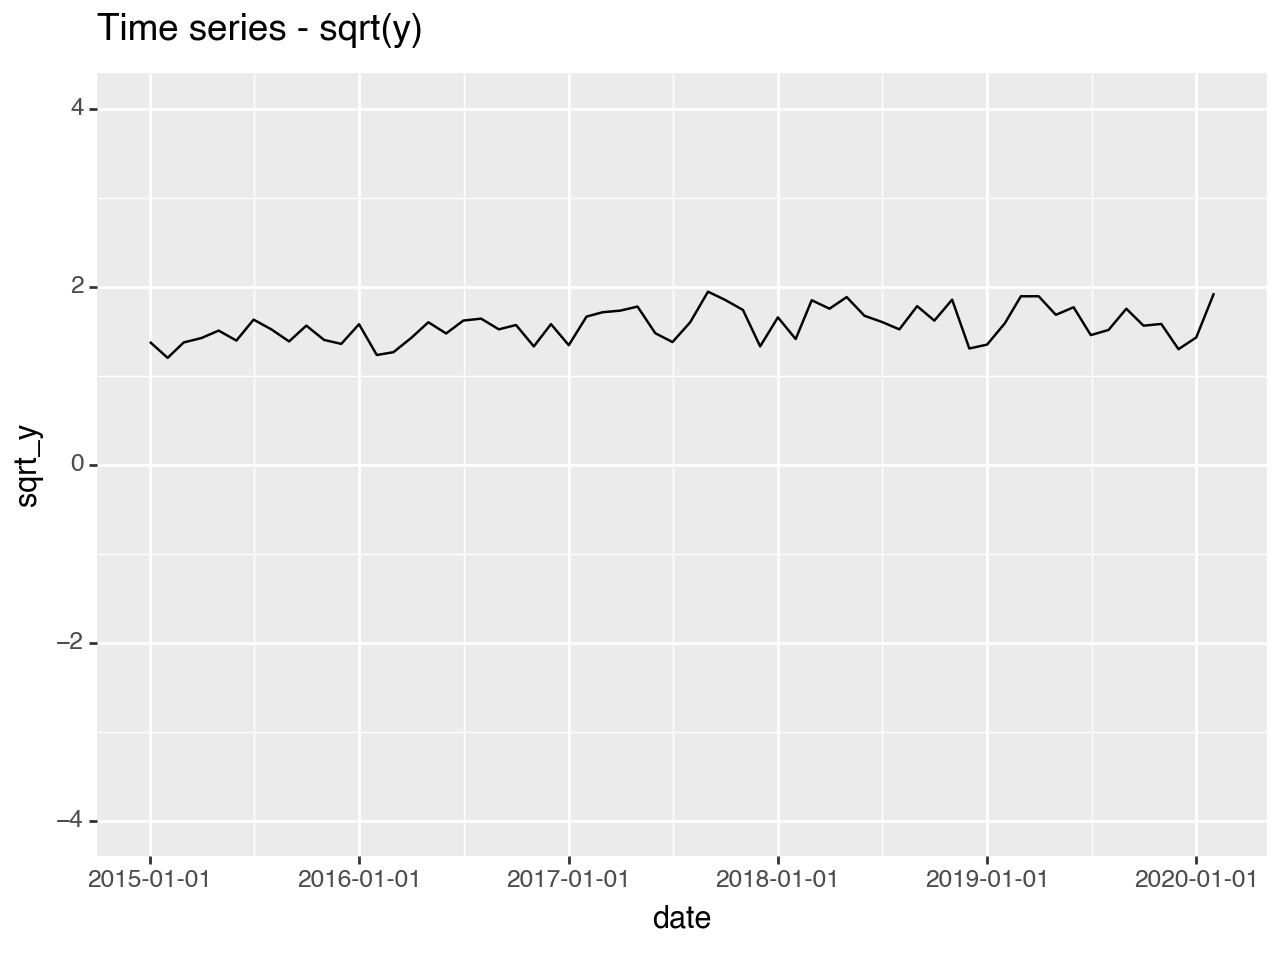

{'pvalue': 0.09917610930715909,
 'stationary': False,
 'test_statistic': -2.5708351044308664,
 'used_lag': 4}

In [10]:
print(
    ggplot(train_data.assign(sqrt_y=train_data["y"] ** 0.5), aes(x="date", y="sqrt_y"))
    + geom_line()
    + coord_cartesian(ylim=[0, (train_data["y"] ** 0.5).max() + 0.5])
    + coord_cartesian(ylim=[-4, 4]) 
    + labs(title="Time series - sqrt(y)")
)
test_stationary(train_data['y']**0.5)

/Users/adamnavarroliriano/miniconda3/envs/forecast/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


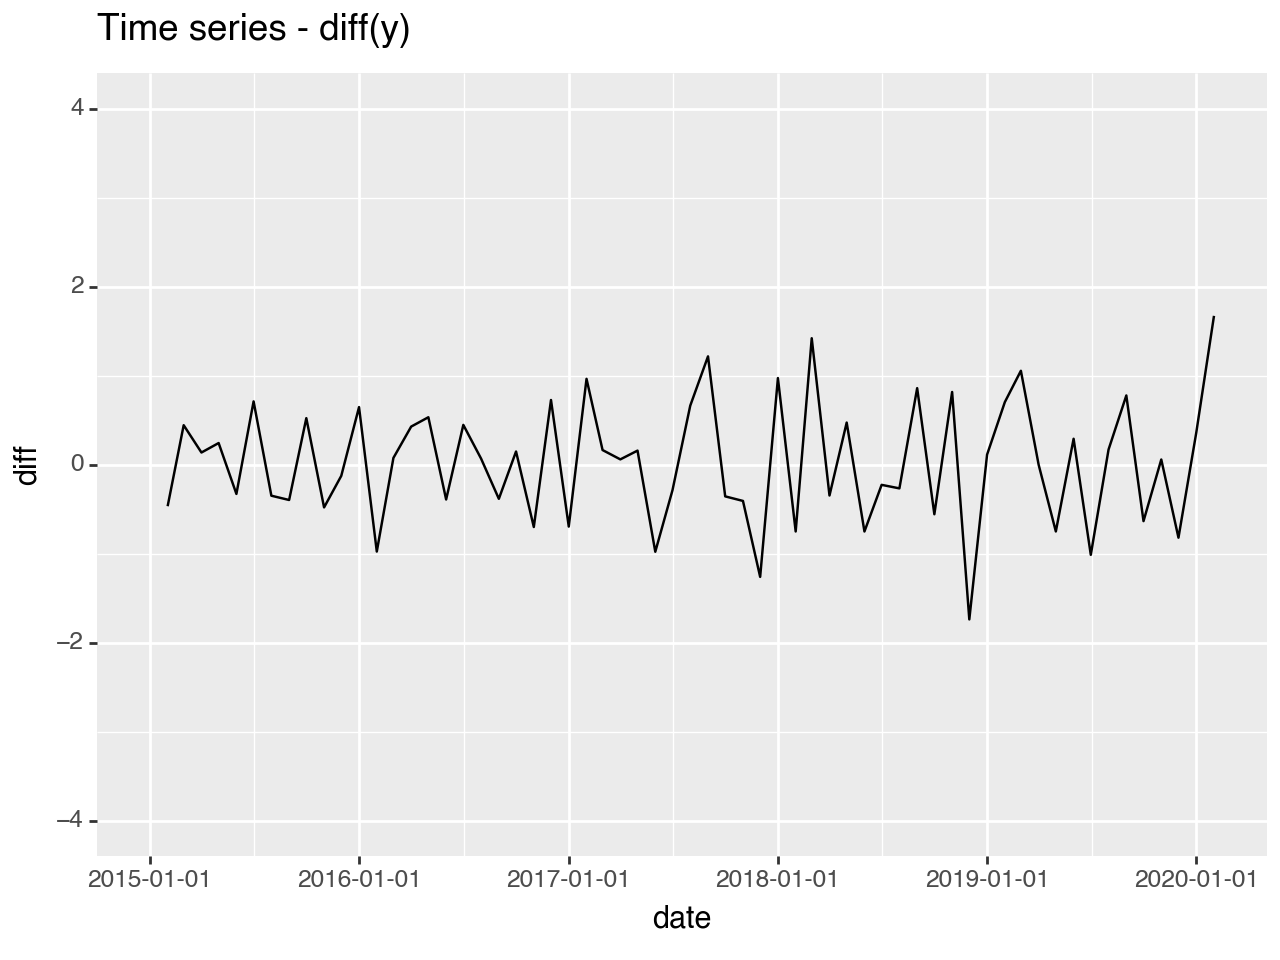


{'pvalue': 2.91514923639719e-09, 'stationary': True, 'test_statistic': -6.753229230577443, 'used_lag': 4}


In [11]:
train_diff = train_data.copy()
train_diff["diff"] = train_diff["y"].diff()

print(
    ggplot(train_diff, aes(x="date", y="diff"))
    + geom_line()
    + coord_cartesian(ylim=[train_diff["diff"].min(), train_diff["diff"].max() + 0.5])
    + coord_cartesian(ylim=[-4, 4]) 
    + labs(title="Time series - diff(y)")
)
print(test_stationary(train_diff['diff']))

/Users/adamnavarroliriano/miniconda3/envs/forecast/lib/python3.8/site-packages/plotnine/geoms/geom_path.py:98: PlotnineWarning: geom_path: Removed 1 rows containing missing values.


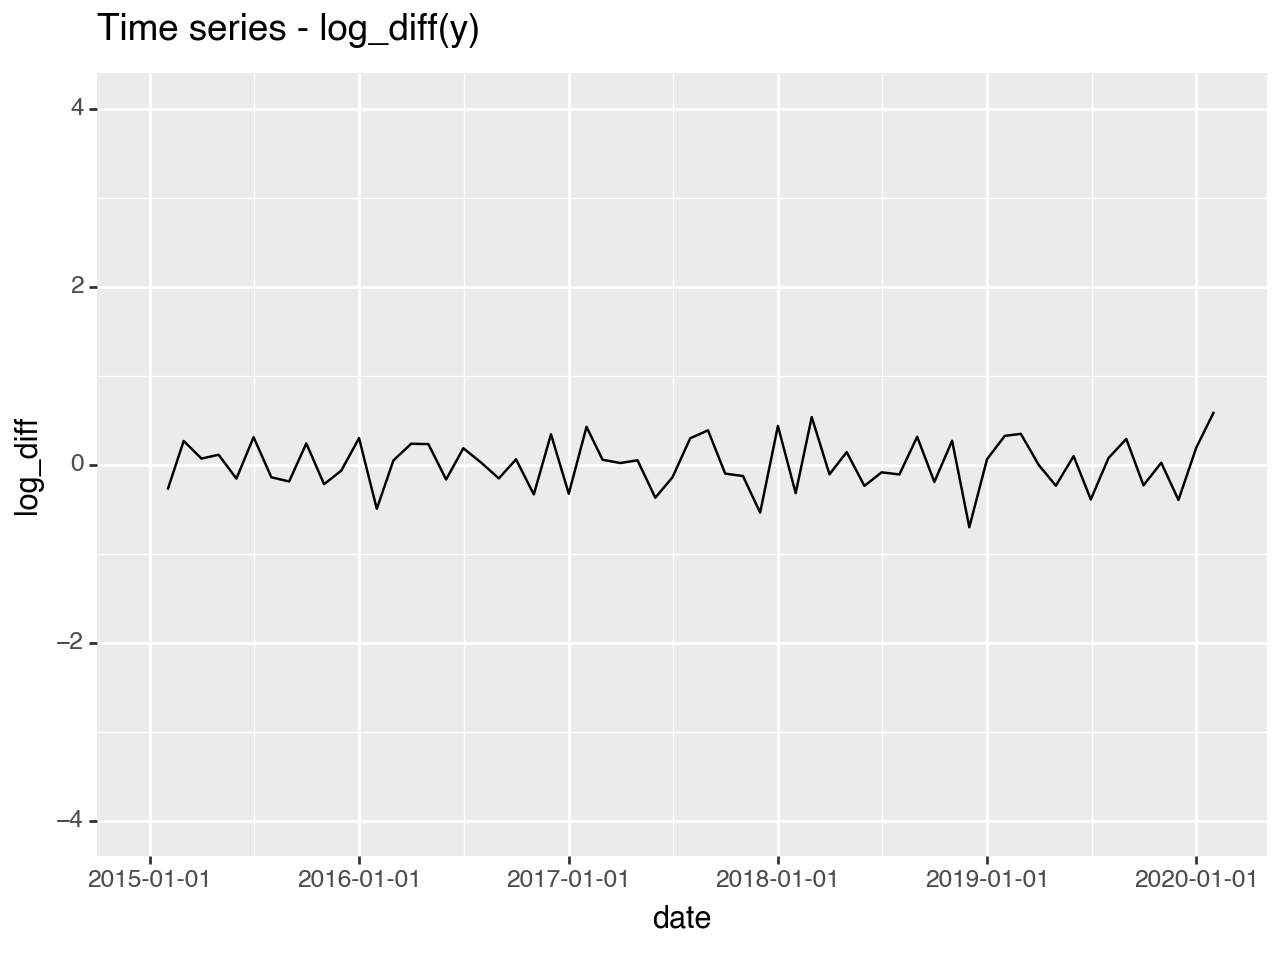


{'pvalue': 8.507831679393432e-09, 'stationary': True, 'test_statistic': -6.558267699434466, 'used_lag': 4}


In [12]:
train_log_diff= train_data.copy()
train_log_diff['log_diff'] = np.log(train_log_diff['y']).diff()
print(
    ggplot(train_log_diff, aes(x="date", y="log_diff"))
    + geom_line()
    + coord_cartesian(ylim=[train_log_diff["log_diff"].min(), train_log_diff["log_diff"].max() + 0.5])
    + coord_cartesian(ylim=[-4, 4]) 
    + labs(title="Time series - log_diff(y)")
)
print(test_stationary(train_log_diff['log_diff']))

## Decompose series

In [19]:
# 12 periods
y = train_data['y'].reset_index(drop=True)
y = np.log(y)
seasonal_decomposition = seasonal_decompose(y, period=12)

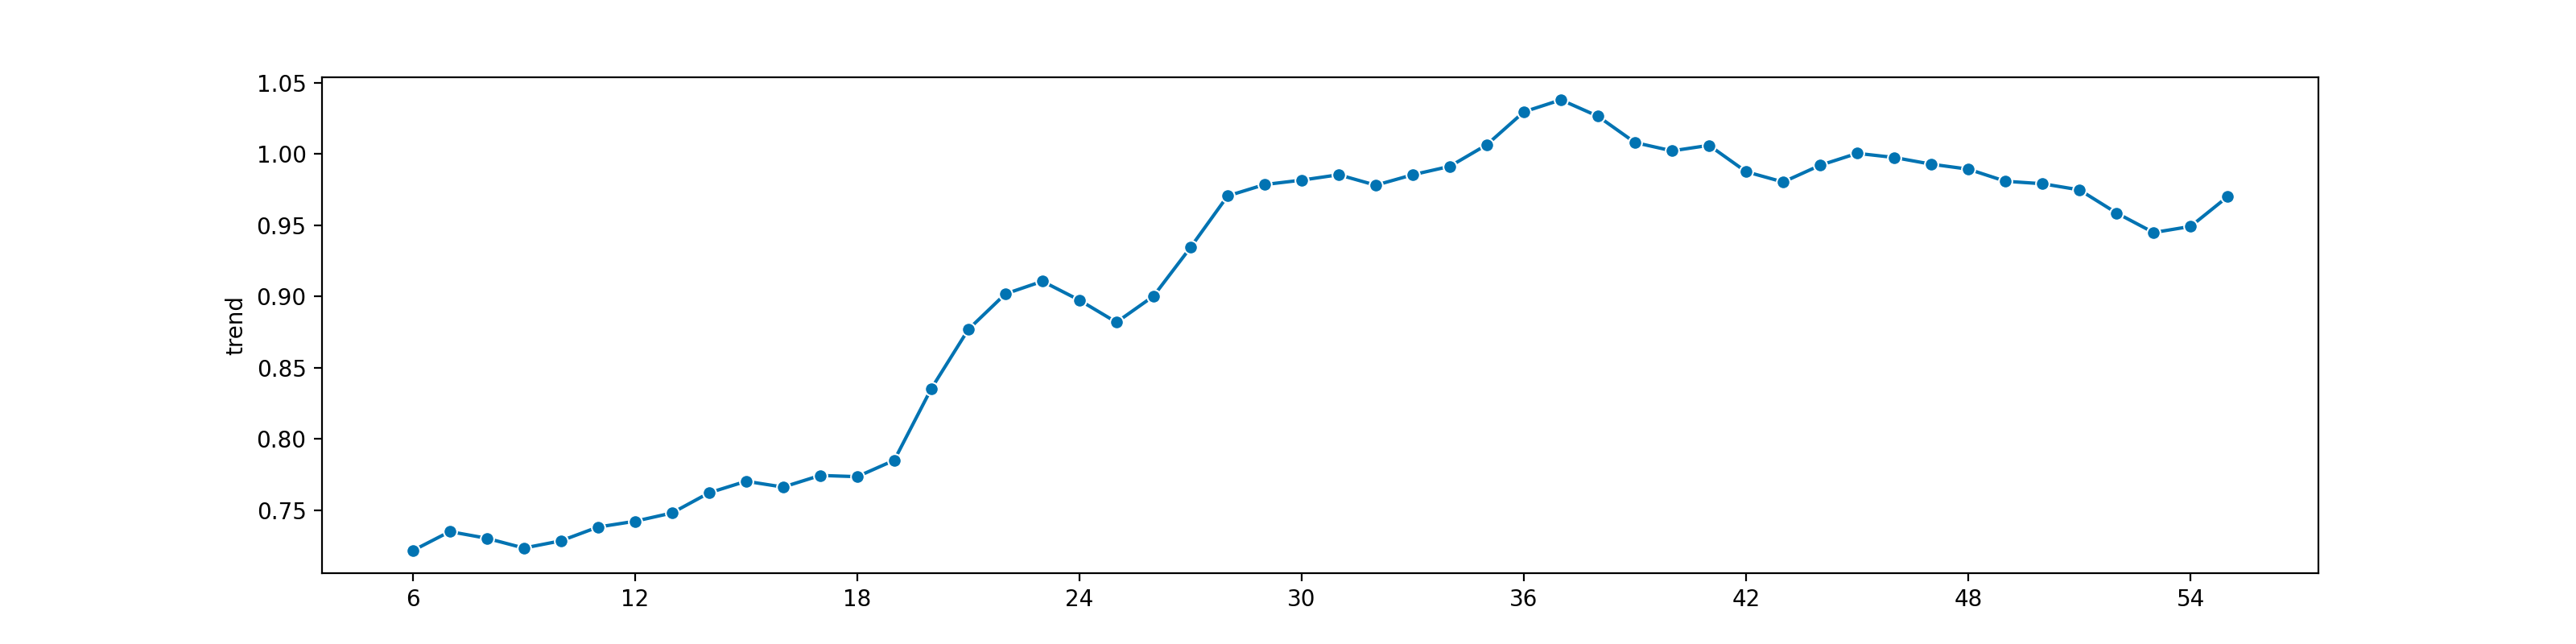

In [20]:
plot_series(seasonal_decomposition.trend)
plt.show()

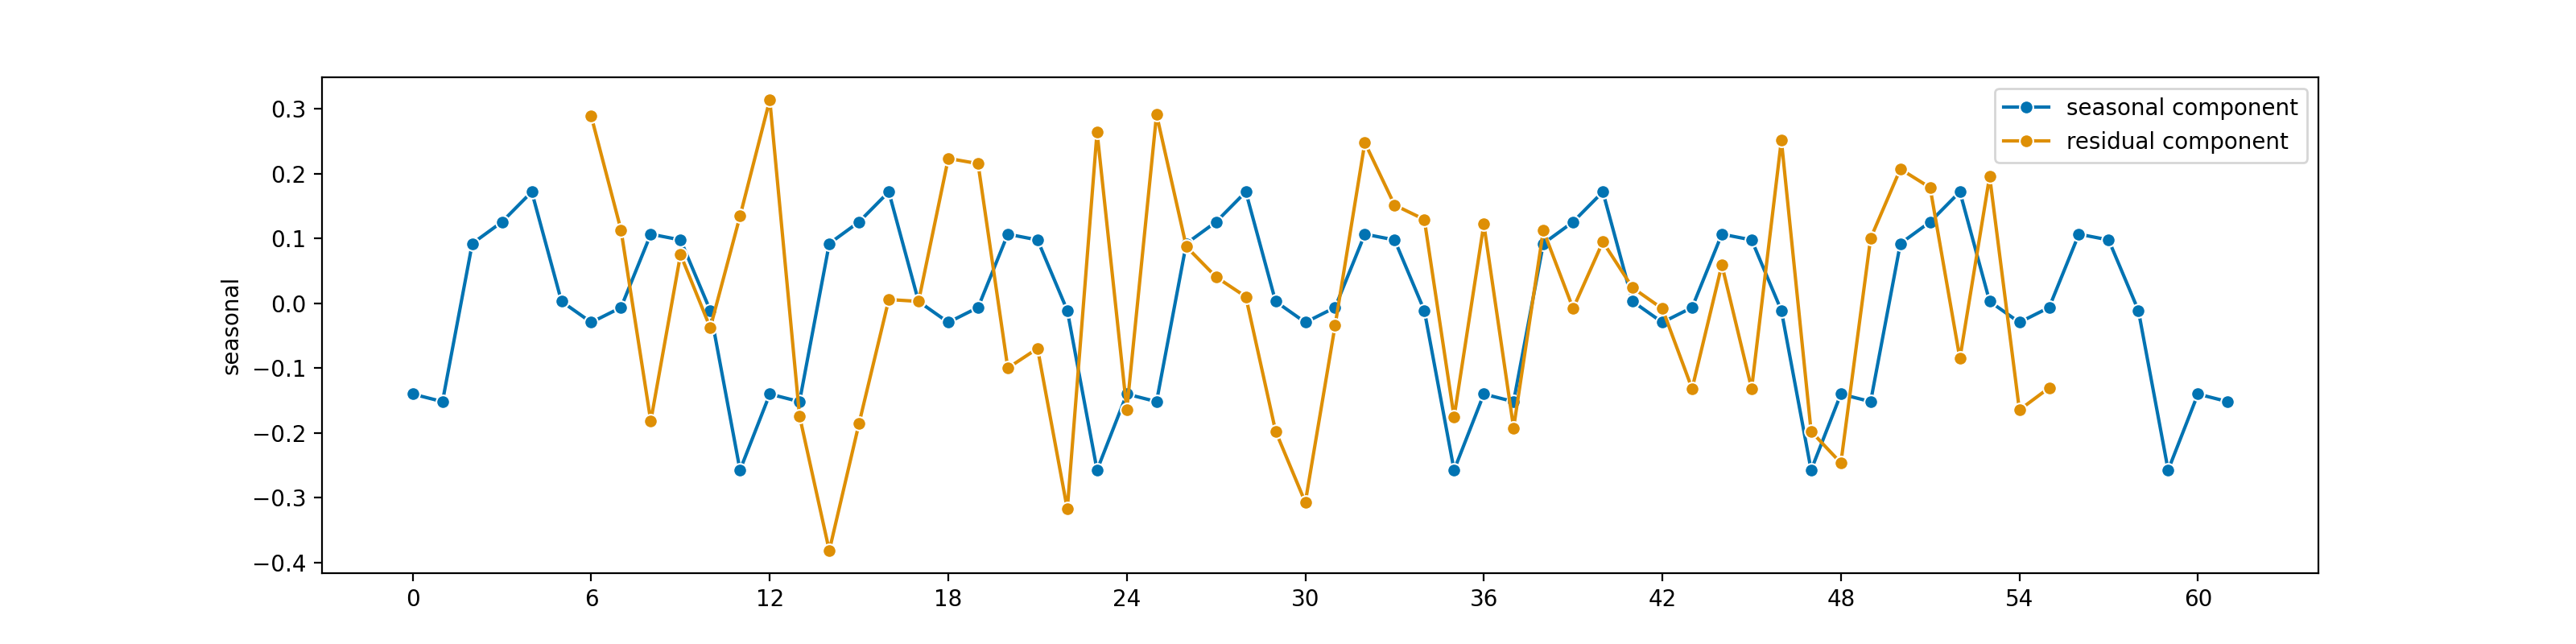

In [21]:

plot_series(seasonal_decomposition.seasonal, seasonal_decomposition.resid,
            labels=["seasonal component", "residual component"])
plt.xticks(np.arange(0, y.index.max(), 6))
plt.show()

## Squared root transformation

In [91]:
y = train_data['y'].reset_index(drop=True)
y = y**0.5
seasonal_decomposition = seasonal_decompose(y, period=6)

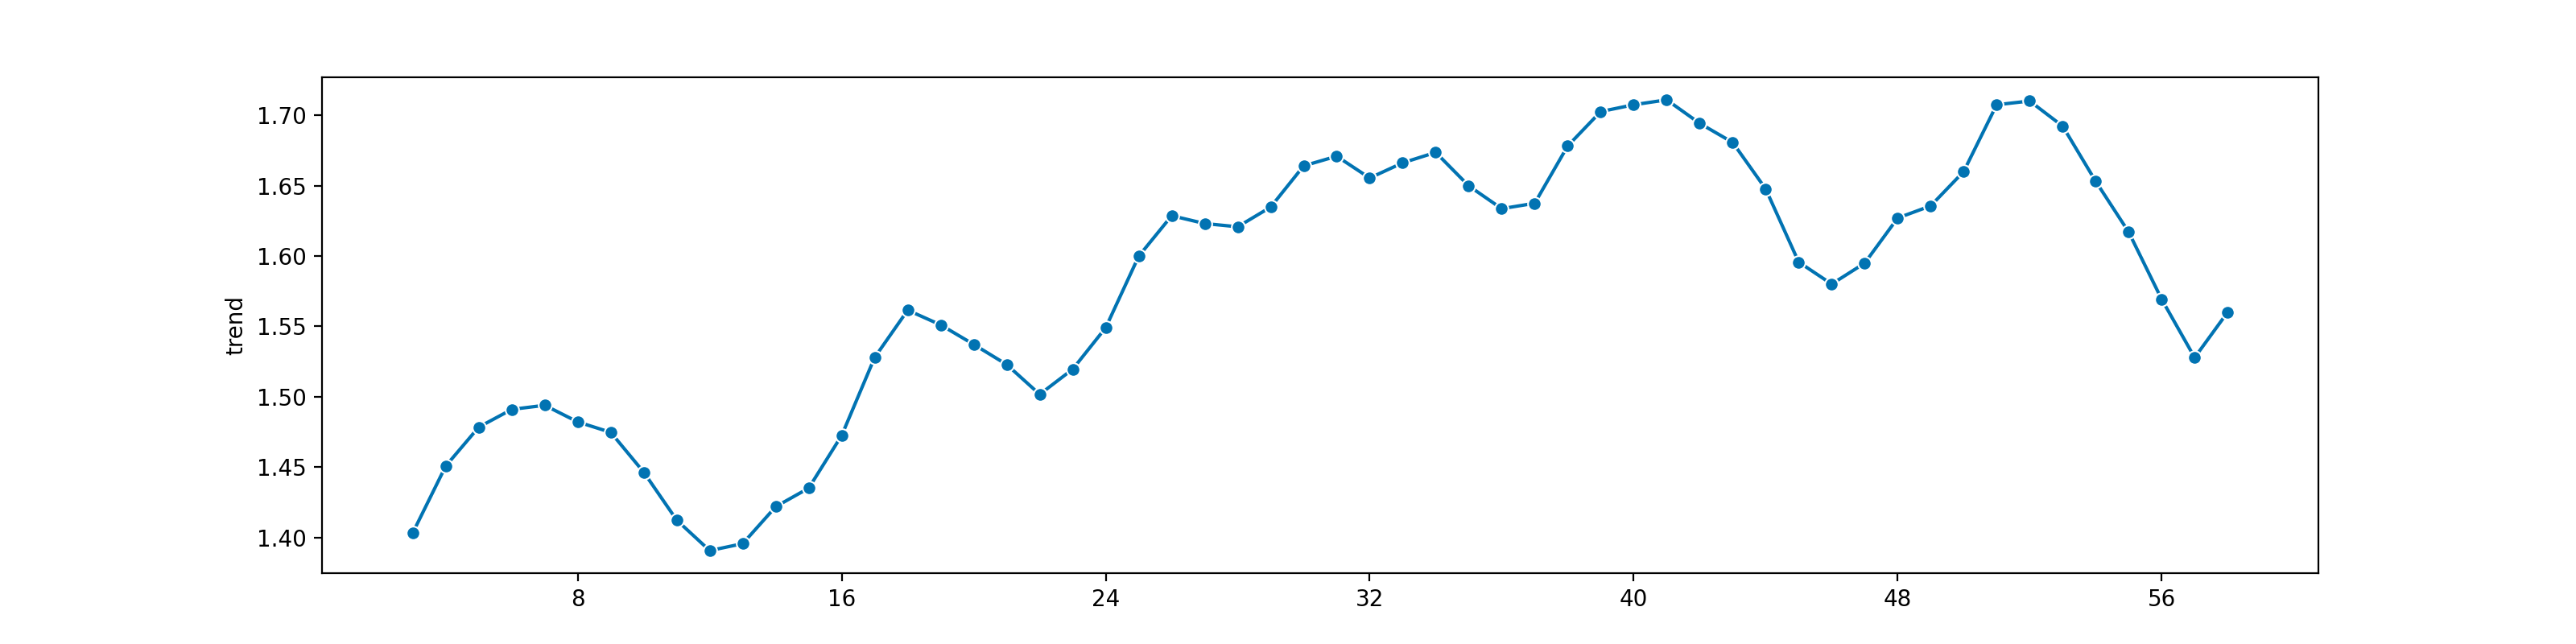

In [92]:
plot_series(seasonal_decomposition.trend)
plt.show()

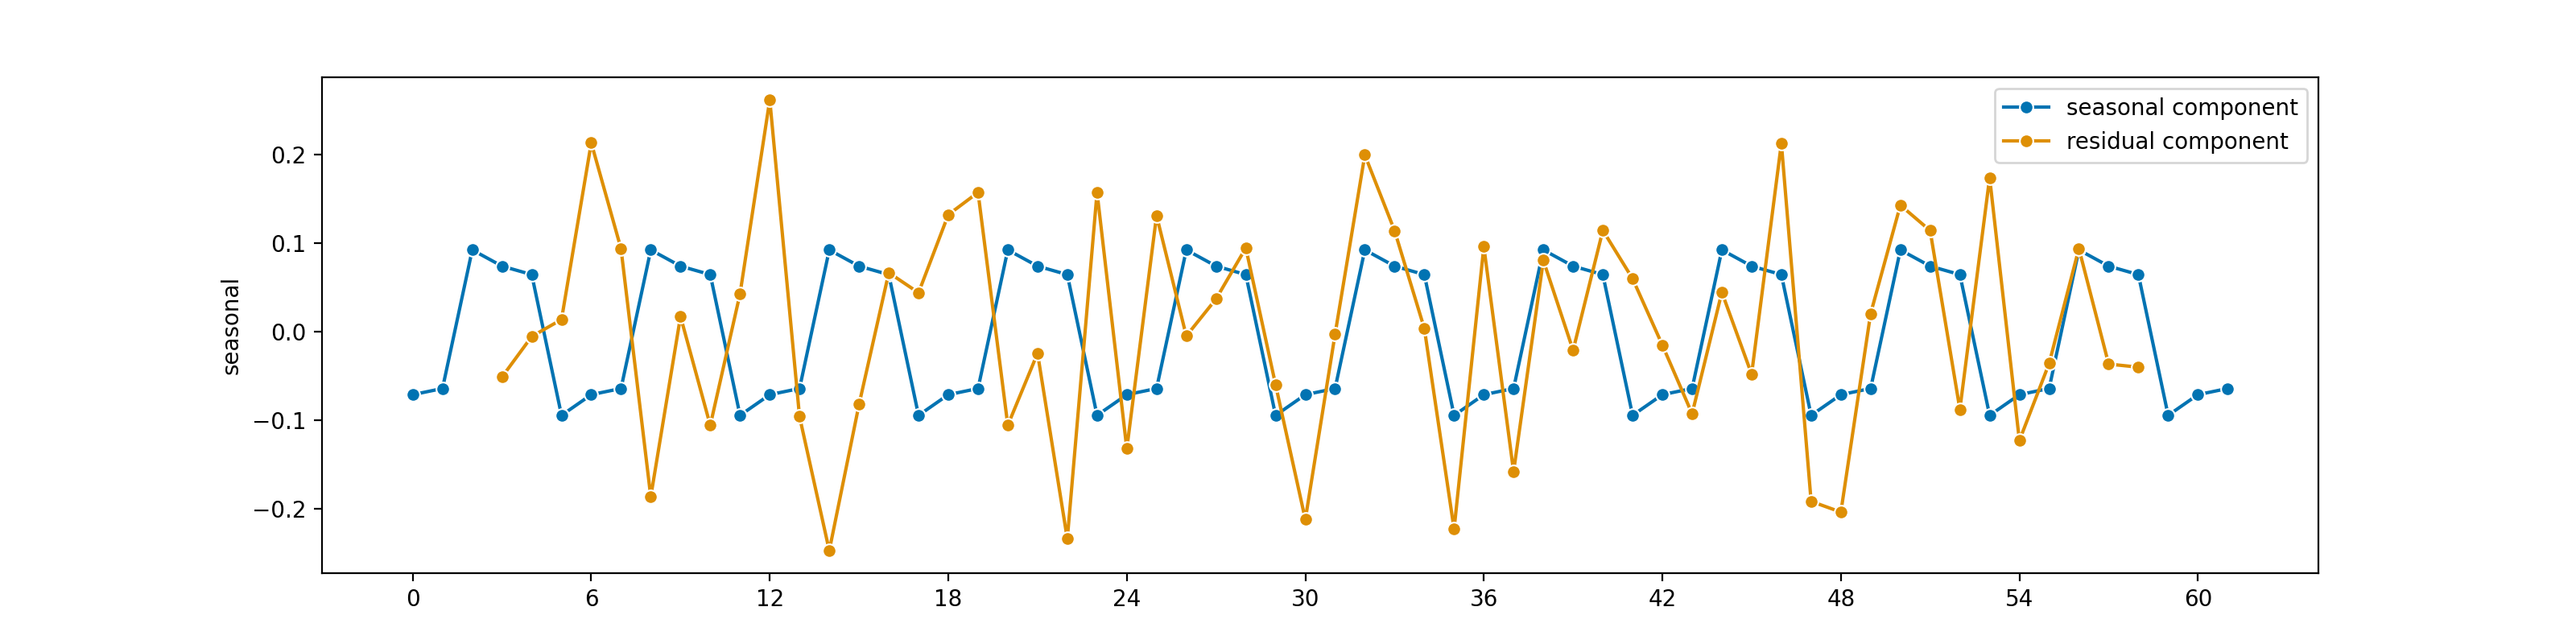

In [93]:

plot_series(seasonal_decomposition.seasonal, seasonal_decomposition.resid,
            labels=["seasonal component", "residual component"])
plt.xticks(np.arange(0, y.index.max(), 6))
plt.show()